In [40]:
# Importing libraries

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import keras as keras

import tensorflow as tf 
print(tf.__version__) # Checking the version of tensorflow

1.12.0


In [2]:
# Fixing a crashing problem

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

In [4]:
# Create a function the generates a drawing

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

In [5]:
# Create a function the generates a rectangle

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

In [6]:
# Create a function the generates a disk

def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

In [7]:
# Create a function the generates a triangle

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

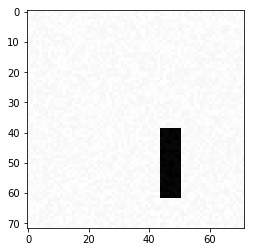

In [8]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

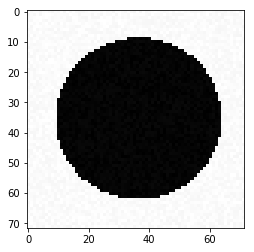

In [9]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

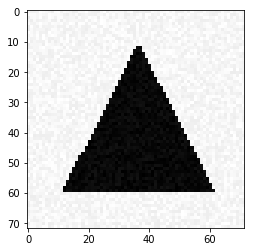

In [10]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [11]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [12]:
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = keras.utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [13]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [14]:
import matplotlib.patches as patches

In [15]:
def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

In [16]:
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

In [17]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


# 3 - Simple Classification

## Stochastic Gradient Descent Optimizer

In [18]:
# Import the necessary libraries

from keras import optimizers
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.optimizers import sgd
from keras.metrics import categorical_crossentropy
from keras import metrics

Using TensorFlow backend.


In [19]:
inp_shape = X_train.shape[1] # Store the input shape

Y_train = tf.keras.utils.to_categorical(Y_train) # Change Y_train into categorical values

# CREATING THE NETWORK 
# Sequential stands for step by step
# The first layer (Dense) has 72 neurones (IMAGE_SIZE) and needs to know what is the input shape
# The output layer has 3 neurones which matches the number of classes of our problem

model_SGD = Sequential([Dense(72, input_shape = (inp_shape,), activation = tf.nn.softmax),
                       Dense(3, activation = 'softmax',input_shape=(inp_shape,))])

# COMPILING THE MODEL

model_SGD.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
print(inp_shape) # Checking the imput

5184


In [21]:
model_SGD.summary() # Checking the characteristics of our network (SGD)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 72)                373320    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 219       
Total params: 373,539
Trainable params: 373,539
Non-trainable params: 0
_________________________________________________________________


In [22]:
# TRAINING THE MODEL
# Batch size is how many samples the model will group while training

model_SGD.fit(X_train, Y_train, epochs = 75, batch_size = 32)

Epoch 1/75
300/300 [==============================] - 1s 2ms/step - loss: 1.0955 - acc: 0.3367
Epoch 2/75
300/300 [==============================] - 0s 146us/step - loss: 1.0915 - acc: 0.4133
Epoch 3/75
300/300 [==============================] - 0s 126us/step - loss: 1.0872 - acc: 0.4067
Epoch 4/75
300/300 [==============================] - 0s 119us/step - loss: 1.0824 - acc: 0.4033
Epoch 5/75
300/300 [==============================] - 0s 119us/step - loss: 1.0787 - acc: 0.4700
Epoch 6/75
300/300 [==============================] - 0s 123us/step - loss: 1.0750 - acc: 0.4400
Epoch 7/75
300/300 [==============================] - 0s 121us/step - loss: 1.0696 - acc: 0.4100
Epoch 8/75
300/300 [==============================] - 0s 120us/step - loss: 1.0635 - acc: 0.5600
Epoch 9/75
300/300 [==============================] - 0s 122us/step - loss: 1.0558 - acc: 0.5100
Epoch 10/75
300/300 [==============================] - 0s 122us/step - loss: 1.0475 - acc: 0.5867
Epoch 11/75
300/300 [==========

In [26]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model_SGD.predict(X_test)

array([[0.2712967 , 0.6133124 , 0.11539079]], dtype=float32)

## Adam Optimizer

In [41]:
[X_train, Y_train] = generate_dataset_classification(300, 20) # Recreating a testing set

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [42]:
[X_test, Y_test] = generate_dataset_regression(300, 20) # Creating the testing set

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [43]:
inp_shape = X_train.shape[1] # Store the input shape

Y_train = tf.keras.utils.to_categorical(Y_train) # Change Y_train into categorical values

# CREATING THE NETWORK (Adam)
# The first layer (Dense) has 72 neurones (IMAGE_SIZE) and needs to know what is the input shape
# The output layer has 3 neurones which matches the number of classes of our problem

model_Ad = Sequential([
    Dense(72, input_shape = (inp_shape,), activation = 'relu'), 
    Dense(3, activation = tf.nn.softmax)
])

# COMPILING THE MODEL (Adam)

model_Ad.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
model_Ad.summary() # Checking the characteristics of our network (Adam)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 72)                373320    
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 219       
Total params: 373,539
Trainable params: 373,539
Non-trainable params: 0
_________________________________________________________________


In [45]:
model_Ad.fit(X_train, Y_train, epochs=75, batch_size=32)

Epoch 1/75
300/300 [==============================] - 1s 2ms/step - loss: 3.8184 - acc: 0.3700
Epoch 2/75
300/300 [==============================] - 0s 242us/step - loss: 0.8563 - acc: 0.6067
Epoch 3/75
300/300 [==============================] - 0s 241us/step - loss: 0.4901 - acc: 0.8067
Epoch 4/75
300/300 [==============================] - 0s 244us/step - loss: 0.3831 - acc: 0.8667
Epoch 5/75
300/300 [==============================] - 0s 225us/step - loss: 0.3097 - acc: 0.9133
Epoch 6/75
300/300 [==============================] - 0s 222us/step - loss: 0.3071 - acc: 0.8433
Epoch 7/75
300/300 [==============================] - 0s 227us/step - loss: 0.2659 - acc: 0.8767
Epoch 8/75
300/300 [==============================] - 0s 225us/step - loss: 0.2716 - acc: 0.8667
Epoch 9/75
300/300 [==============================] - 0s 238us/step - loss: 0.2396 - acc: 0.8800
Epoch 10/75
300/300 [==============================] - 0s 222us/step - loss: 0.1779 - acc: 0.9500
Epoch 11/75
300/300 [==========

In [46]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model_Ad.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

# 4 - Visualization of the Solution

In [47]:
%matplotlib inline

visu = model_SGD.get_weights()[0] # Checking the visualization of the SGD model
array_1 = visu[:,0]
array_2 = visu[:,1]
array_3 = visu[:,2]

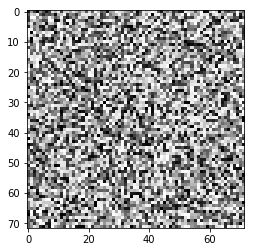

In [48]:
import matplotlib.cm as cm
plt.imshow(array_1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap = cm.Greys) # Choose the color grey for the figure
plt.show()

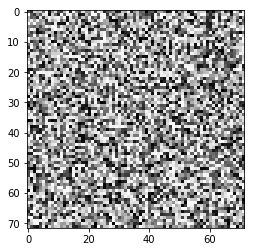

In [49]:
plt.imshow(array_2.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap = cm.Greys)
plt.show()

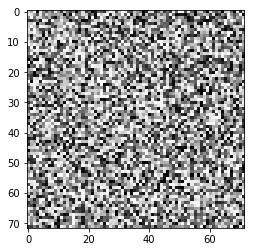

In [50]:
plt.imshow(array_3.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap = cm.Greys)
plt.show()

# 5 - A more Difficult Classification Problem

In [51]:
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D

In [52]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True) # Recreating the testing set

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [53]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [55]:
#Reshape the data
X_train = X_train.reshape([-1,72,72,1])
print(X_train.shape)
inp_shape = X_train.shape[1] 
inp_rows = X_train.shape[2]
print(inp_shape, inp_rows)

(300, 72, 72, 1)
72 72


In [56]:
#Transform the target to categorical 
Y_train = tf.keras.utils.to_categorical(Y_train)

# CREATING THE MODEL (Convolutional)

model_convolutional = Sequential() 

# Adding convolutional and pooling layers

model_convolutional.add(Conv2D(16, kernel_size = 5, activation='relu',  input_shape = (inp_shape,inp_rows,1)))
model_convolutional.add(MaxPool2D(2))
model_convolutional.add(Conv2D(16, kernel_size = 5, activation='relu'))
model_convolutional.add(MaxPool2D(2))

# Connecting convolutional layer to dense layer

model_convolutional.add(Flatten())

model_convolutional.add(Dense(3, activation = 'softmax'))

# COMPILING THE MODEL

model_convolutional.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [57]:
model_convolutional.summary() # Checking the characteristics of the network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 16)        6416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3600)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 10803     
Total params: 17,635
Trainable params: 17,635
Non-trainable params: 0
_________________________________________________________________


In [58]:
#fit the model 
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 2)
model_convolutional.fit(X_train, Y_train, epochs=100, batch_size = 32,validation_split = 0.3, callbacks = [early_stopping])

Train on 210 samples, validate on 90 samples
Epoch 1/100
210/210 [==============================] - 1s 5ms/step - loss: 1.1078 - acc: 0.3333 - val_loss: 1.0592 - val_acc: 0.4778
Epoch 2/100
210/210 [==============================] - 0s 1ms/step - loss: 1.0769 - acc: 0.3952 - val_loss: 1.0513 - val_acc: 0.4667
Epoch 3/100
210/210 [==============================] - 0s 1ms/step - loss: 1.0215 - acc: 0.5333 - val_loss: 1.0310 - val_acc: 0.4000
Epoch 4/100
210/210 [==============================] - 0s 1ms/step - loss: 0.9420 - acc: 0.5571 - val_loss: 0.9335 - val_acc: 0.5444
Epoch 5/100
210/210 [==============================] - 0s 1ms/step - loss: 0.8997 - acc: 0.5714 - val_loss: 0.8796 - val_acc: 0.6333
Epoch 6/100
210/210 [==============================] - 0s 1ms/step - loss: 0.7941 - acc: 0.6905 - val_loss: 0.7793 - val_acc: 0.6667
Epoch 7/100
210/210 [==============================] - 0s 1ms/step - loss: 0.7087 - acc: 0.7619 - val_loss: 0.7179 - val_acc: 0.6889
Epoch 8/100
210/210 [===

In [59]:
#Reshape the data
X_test = X_test.reshape([-1,72,72,1])

#Evaluate test set
model_convolutional.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 334us/step


[0.796605974038442, 0.6466666666666666]

# 6 - A Regression Problem

In [78]:
[X_train, Y_train] = generate_dataset_regression(800, 20) # Recreating a training set

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790


In [63]:
#Reshape X_train
X_train = X_train.reshape([-1, 72,72,1])

# CREATING THE MODEL 

model_reg = Sequential() 

# Adding convolutional and pooling layers

model_reg.add(Conv2D(32, kernel_size = 5, activation='relu',  input_shape = (72,72,1)))
model_reg.add(MaxPool2D(2))
model_reg.add(Conv2D(16, kernel_size = 5, activation='relu',  input_shape = (72,72,1)))
model_reg.add(MaxPool2D(2))
model_reg.add(Conv2D(16, kernel_size = 5, activation='relu',  input_shape = (72,72,1)))

# Connecting convolutional layer to dense layer

model_reg.add(Flatten())
model_reg.add(Dense(6,)) #output layer


model_reg.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [69]:
training = model_reg.fit(X_train, Y_train, epochs = 10, batch_size = 128)

Epoch 1/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0382 - mean_absolute_error: 0.1589
Epoch 2/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0371 - mean_absolute_error: 0.1571
Epoch 3/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0360 - mean_absolute_error: 0.1542
Epoch 4/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0349 - mean_absolute_error: 0.1517
Epoch 5/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0341 - mean_absolute_error: 0.1500
Epoch 6/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0333 - mean_absolute_error: 0.1478
Epoch 7/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0324 - mean_absolute_error: 0.1456
Epoch 8/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0313 - mean_absolute_error: 0.1434
Epoch 9/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0312 - mean_absolute_error: 0.1423
E

In [87]:
[X_test, Y_test] = generate_test_set_regression() # Creating a test set

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [88]:
X_test = X_test.reshape([-1, 72,72,1])
y_pred = model_reg.predict(X_test)

In [89]:
model_reg.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 615us/step


[0.07930933068195979, 0.2240702348947525]

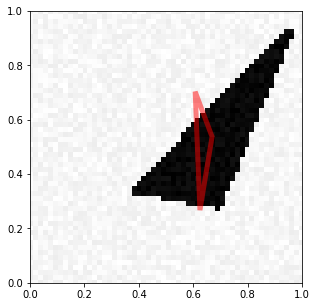

In [90]:
visualize_prediction(X_test[0], y_pred[0])

# 7 - Image Denoising

In [91]:
from keras.layers import Subtract

In [92]:
# Generate pair of images (with noise / without noise)
def generate_a_drawing_n(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_n = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata_n, imdata

def generate_a_rectangle_n(free_location=False):
    noise = np.random.randint(0,100) # noise
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing_n(figsize, U, V, noise)


def generate_a_disk_n(free_location=False):
    noise = np.random.randint(0,100) # noise
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing_n(figsize, U, V, noise)

def generate_a_triangle_n(free_location=False):
    noise = np.random.randint(0,100) # noise
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing_n(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification_n(nb_samples, free_location=False):
    noise = np.random.randint(0,100) # noise
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,2,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle_n(free_location)
        elif category == 1: 
            X[i] = generate_a_disk_n(free_location)
        else:
            [X[i], V] = generate_a_triangle_n(free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [93]:
training, same = generate_dataset_classification_n(800)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790


In [94]:
X_train = training[:,0]
Y_train = training[:,1]

# Reshaping to 4 dimensions
X_train = X_train.reshape(-1, 72,72,1)
Y_train = Y_train.reshape(-1, 72,72,1)

In [96]:
from keras.models import Input, Model
from keras.layers import UpSampling2D
from keras.layers import UpSampling2D

rip = Input(shape=(72, 72, 1))


temp = Conv2D(32, (3, 3), activation='relu', padding='same')(rip)
temp = MaxPool2D((2, 2), padding='same')(temp)
temp = Conv2D(32, (3, 3), activation='relu', padding='same')(temp)
temp = MaxPool2D((2, 2), padding='same')(temp)
temp = Conv2D(32, (3, 3), activation='relu', padding='same')(temp)
temp = UpSampling2D((2, 2))(temp)
temp = Conv2D(32, (3, 3), activation='relu', padding='same')(temp)
temp = UpSampling2D((2, 2))(temp)

output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(temp)
model_denoising = Model(rip, output)
model_denoising.compile(optimizer="adam", loss='binary_crossentropy')
model_denoising.fit(X_train, Y_train, epochs=20, batch_size=128,validation_split=0.3, shuffle=True, callbacks = [early_stopping])

Train on 560 samples, validate on 240 samples
Epoch 1/20
560/560 [==============================] - 12s 21ms/step - loss: 0.6162 - val_loss: 0.5581
Epoch 2/20
560/560 [==============================] - 11s 19ms/step - loss: 0.5519 - val_loss: 0.5436
Epoch 3/20
560/560 [==============================] - 10s 19ms/step - loss: 0.5333 - val_loss: 0.5205
Epoch 4/20
560/560 [==============================] - 11s 19ms/step - loss: 0.5081 - val_loss: 0.4931
Epoch 5/20
560/560 [==============================] - 10s 19ms/step - loss: 0.4786 - val_loss: 0.4590
Epoch 6/20
560/560 [==============================] - 11s 19ms/step - loss: 0.4512 - val_loss: 0.4389
Epoch 7/20
560/560 [==============================] - 11s 19ms/step - loss: 0.4310 - val_loss: 0.4228
Epoch 8/20
560/560 [==============================] - 11s 19ms/step - loss: 0.4192 - val_loss: 0.4145
Epoch 9/20
560/560 [==============================] - 10s 19ms/step - loss: 0.4110 - val_loss: 0.4077
Epoch 10/20
560/560 [===============

In [97]:
testing, same = generate_dataset_classification_n(5, 20) # Creating a test set

Creating data:
0


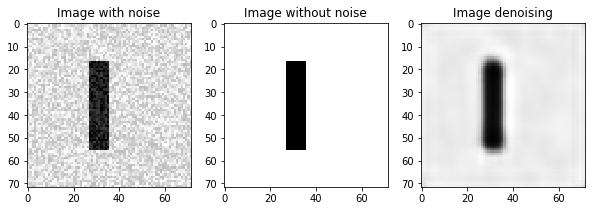

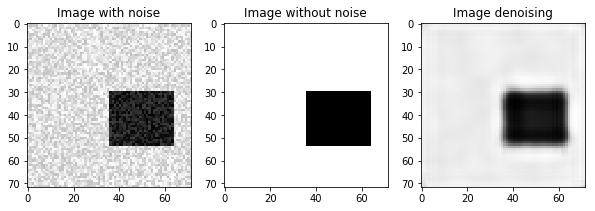

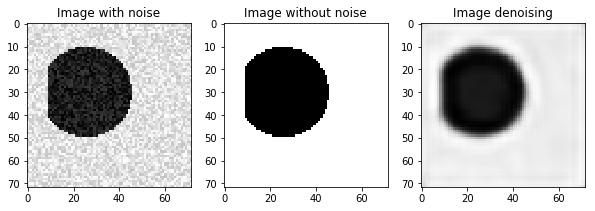

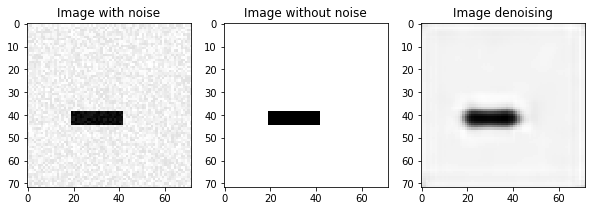

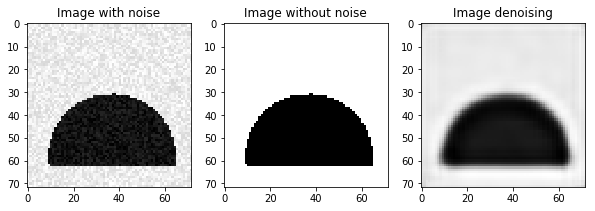

In [98]:
#prepare test set and reshape
X_test = testing[:,0]
Y_test = testing[:,1]
X_test = X_test.reshape(-1,72,72,1)
Y_test = Y_test.reshape(-1,72,72,1)
for j in range(5):
  fig = plt.figure(figsize = (10,20))
  fig.tight_layout()
    
  ax = plt.subplot(1, 3, 1)
  plt.imshow(X_test[j].reshape((72,72)),cmap='gray')
  plt.title("Image with noise")

  ax = plt.subplot(1, 3, 2)
  plt.imshow(Y_test[j].reshape((IMAGE_SIZE,IMAGE_SIZE)),cmap='gray')
  plt.title("Image without noise")

  ax = plt.subplot(1, 3, 3)
  plt.imshow((model_denoising.predict(X_test[j].reshape((-1,72,72,1)))).reshape((72,72)),cmap='gray')
  plt.title("Image denoising")